# Load packages

In [1]:
import sys
import os
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D, StandardScaler2D, seed_everything
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import matplotlib.pyplot as plt
from keras import backend as K
import scipy.io as scio
from scipy import stats
from echo.src.base_objective import BaseObjective
from echo.src.pruners import KerasPruningCallback
sys.path.append('/glade/work/fanda/optimization/echo_opt')
sys.path.append('/glade/work/fanda/util/goes16ci/goes16ci')
#from models_test import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
import optuna
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2023-05-22 23:13:00.793744: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.
2023-05-22 23:13:10.637703: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-22 23:13:10.638972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-22 23:13:10.650936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-22 23:13:10.650965: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-05-22 23:13:10.670203: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-05-22 23:13:10.670307: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic l

# Load training and testing data

In [3]:
#def main():
seed_everything(4835)
My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC'#GOESR_HRRR_PC/'
train_dir = My_dir+'/train_20/' 
test_dir = My_dir+'/test_21/'
onlyfiles = [f for f in listdir(train_dir) if isfile(join(train_dir, f))]
testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

config_file = open('/glade/work/fanda/optimization/benchmark_config_default_echo_best_resnet.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
print(config["dtype"])
# load data serial
logging.info("Split training and validation data")
train = []
label = []
test = []
test_label = []
lat_1 = []
lon_1 = []
date_1 = []
Type_1 = []
lat_train = []
lon_train = []
Type_train = []
benchmark_data = dict()
# load data serial
benchmark_data["config"] = config
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(train_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
    lat_1.append(processed_file.variables['lat_0'])
    lon_1.append(processed_file.variables['lon_0'])
    Type_1.append(processed_file.variables['Type'])
all_images = np.concatenate(train).astype(config["dtype"])
all_labels = np.concatenate(label).astype(config["dtype"])
lat_train = np.concatenate(lat_1).astype(config["dtype"])
lon_train = np.concatenate(lon_1).astype(config["dtype"])
Type_train = np.concatenate(Type_1).astype(config["dtype"])
all_images = np.moveaxis(all_images,1,-1)
delete_row =[]
for i in range(len(all_labels)):
    if np.sum(np.isnan(all_images[i,:,:,:]))>0 or np.max(all_images[i,:,:,:])>60000:
        delete_row.append(i)
    elif Type_train[i] > 1:
        if lon_train[i] > -91-0.5 or lon_train[i] < -104+0.5 \
        or lat_train[i] > 48-0.5 or lat_train[i] <34+0.5:
            delete_row.append(i)
lat_1 = []
lon_1 = []
Type_1 = []
all_images = np.delete(all_images, delete_row, 0)
all_labels = np.delete(all_labels, delete_row, 0)
delete_row =[]
for file in testfiles:
    processed_file = nc.Dataset(os.path.join(test_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    if file.endswith("RM.nc"):
        half_size=int(np.shape(processed_file.variables['label'])[0]/2)
        test.append(processed_file.variables['predictor'][:half_size,:,:,:])
        test_label.append(processed_file.variables['label'][:half_size])
        lat_1.append(processed_file.variables['lat_0'][:half_size])
        lon_1.append(processed_file.variables['lon_0'][:half_size])
        date_1.append(processed_file.variables['date'][:half_size])
        Type_1.append(processed_file.variables['Type'][:half_size])
    else:
        test.append(processed_file.variables['predictor'])
        test_label.append(processed_file.variables['label'])
        lat_1.append(processed_file.variables['lat_0'])
        lon_1.append(processed_file.variables['lon_0'])
        date_1.append(processed_file.variables['date'])
        Type_1.append(processed_file.variables['Type'])
test_images = np.concatenate(test).astype(config["dtype"])
test_labels = np.concatenate(test_label).astype(config["dtype"])
lat_0 = np.concatenate(lat_1).astype(config["dtype"])
lon_0 = np.concatenate(lon_1).astype(config["dtype"])
date_0 = np.concatenate(date_1).astype(config["dtype"])
Type_0 = np.concatenate(Type_1).astype(config["dtype"])
test_images = np.moveaxis(test_images,1,-1)
for i in range(len(test_labels)):
    if np.sum(np.isnan(test_images[i,:,:,:]))>0 or np.max(test_images[i,:,:,:])>60000:
        delete_row.append(i)
    elif Type_0[i] > 1:
        if lon_0[i] > -91-0.5 or lon_0[i] < -104+0.5 \
        or lat_0[i] > 48-0.5 or lat_0[i] <34+0.5:
            delete_row.append(i)
test_images = np.delete(test_images, delete_row, 0)
test_labels = np.delete(test_labels, delete_row, 0)
lat_0= np.delete(lat_0, delete_row, 0)
lon_0= np.delete(lon_0, delete_row, 0)
date_0= np.delete(date_0, delete_row, 0)
Type_0= np.delete(Type_0, delete_row, 0)
num = np.shape(all_images)[0]
shuffler = np.random.permutation(len(all_images))

# Shuffle the data
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]

# Split the data
train_val_split = int(num*0.7)#25000
num_ch = np.arange(7,14)#np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])

# Normalization using mean and std
scaler = StandardScaler2D()
train_data_scaled = scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

float32
(45077, 32, 32, 7)
(19320, 32, 32, 7)
(30221, 32, 32, 7)


## Load indices for best hit, worst false alarm, and worst miss

In [5]:
import scipy.io as scio
test_lead10_all_indices = scio.loadmat("test_lead10_all_indices.mat")
print(test_lead10_all_indices["best_hit_indices"])

[[ 8409 12452 12988 15449 29203 11162   976   852  1282  4654  5047 13765
  14748 12089 12295 11805 18642 28946 25990 24704 12014 23555 14814 25339
  12871 19747 17627 21956  4162 29219 28419 28947 21824 11393 24925 26478
  19604 26111 20303 16546  7943 11357 27362  5878  3168 25136 18874 10083
   5335  8423 13616  2672 28190 29997  1218  3202 25118 22388 12119   653
  29132 16829 12269 19852 21051 22019 16426  6441 29650  1940 25797 23567
  11261 14914 24556  8033  6300  5576 18516 15350 29176 23198 29480 11795
   9276  3042 29736 12646 10210 23195 24128 22011 21480 16947 22676  5416
  15432  4332 10287  2004]]


# Plot miss case

### Load radar reflectivity 

In [ ]:
# For miss case:
import datetime
def time_plus_2h(initial_date):
    return str(datetime.datetime.strptime(initial_date,'%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=2))
i=10
index=test_lead10_all_indices["worst_miss_indices"][0]
lon_center = lon_0[index[i]]
lat_center = lat_0[index[i]]
print(time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[i]]))))
print(lon_0[index[i]])
print(lat_0[index[i]])
My_dir = '/glade/scratch/fanda/files/MergedReflectivityQCComposite/28/MergedReflectivityQCComposite/00.50'
testfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
#testfiles.sort
files = []
for i in testfiles:
    if i[9:15]>'012700' and i[9:15]<'022900':
        files.append(i)
files=sorted(files)
print(len(files))
processed_file=nc.Dataset(os.path.join(My_dir,files[0]))
dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
interval = processed_file.LatGridSpacing
lon_grid, lat_grid = np.meshgrid(np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval),
                                 np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[0],-interval))
lat_target_0 = lat_center-0.24#42.75-0.1#34.93#39#34.93 43.23 -98.14 42.75 -97.66
lat_target_1 = lat_center+0.24 #43.23+0.1#35.41#42#35.41+0.01
lon_target_0 = lon_center-0.24#-98.14-0.1#-98.79#-99#-98.79
lon_target_1 = lon_center+0.24#-97.66+0.1#-98.31#-96#-98.31-0.01
lon_1d = np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval)
lat_1d = np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[1],-interval)
lat_index_0 = np.where(np.abs(lat_1d-lat_target_0)<0.001)
lat_index_1 = np.where(np.abs(lat_1d-lat_target_1)<0.001)
lon_index_0 = np.where(np.abs(lon_1d-lon_target_0)<0.001)
lon_index_1 = np.where(np.abs(lon_1d-lon_target_1)<0.001)

### Load satellite observation and make the plot

247.73308
248.21875
247.91023
246.34996
245.65971
246.45679
247.85356


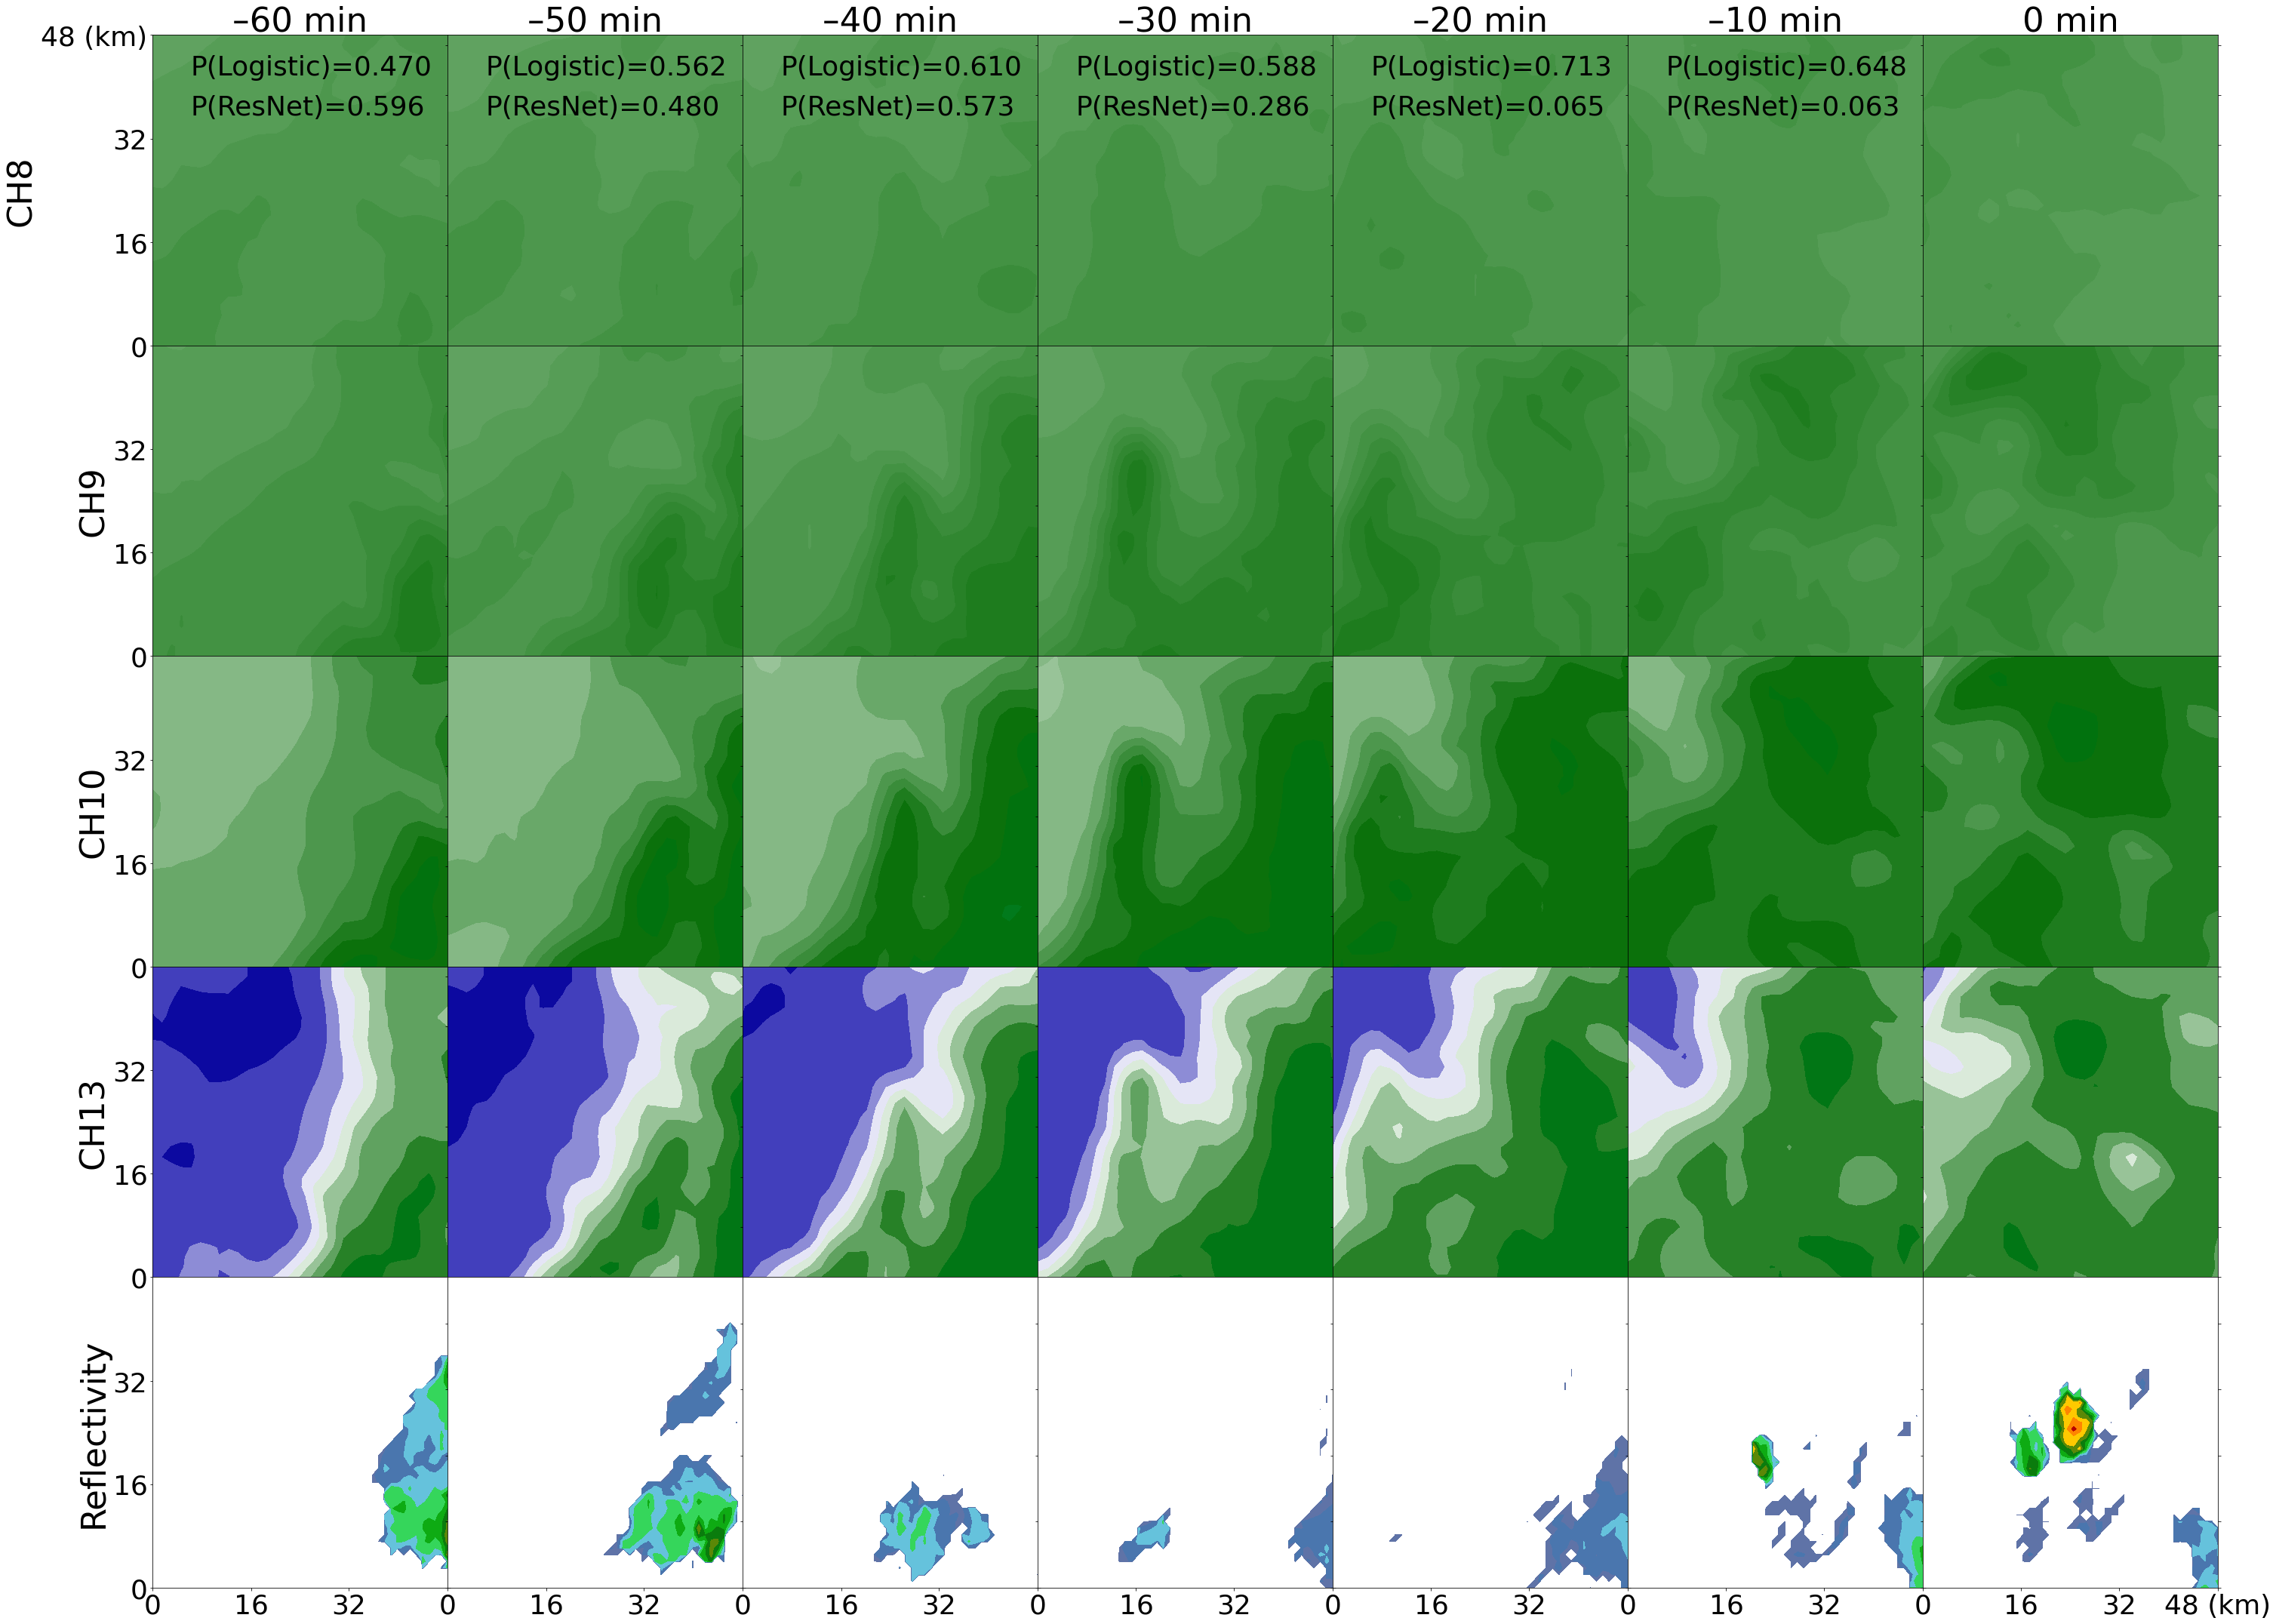

In [122]:
%matplotlib inline
from metpy.plots import colortables
index=test_lead10_all_indices["worst_miss_indices"][0]
vmin = [205,210,220,195,201,190,190]
vmax = [300,315,315,365,315,385,385] 
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
log_pred = ['0.470', 0.562, '0.610', 0.588, 0.713, 0.648]
res_pred = [0.596, '0.480', 0.573, 0.286, 0.065, 0.063]
ch = [8, 9, 10, 13]
row = 5#0
column = 7
ctable = ('NWSStormClearReflectivity',-20,0.45)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)     
x_index = np.ones(28)*10
y_index = np.ones(28)*38
x_array = np.arange(10,38,1)
y_array = np.arange(10,38,1)
vmin_all = 160
vmax_all = 410
WV_min = [210, 215, 220, 220]
WV_max = [290, 300, 305, 335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        if i < 4:
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[10],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all, \
                                      cmap=wv_cmap, norm=wv_norm, N=500)
            if i == 3:
                print(np.min(np.squeeze(test_images_shuffled[index[10],:,:,ch[i]-8+j*7])))
            if j == 0:
                ax[i][j].set_ylabel('CH'+str(ch[i]),fontsize=45)
            if i == 0:
                if j != 6:
                    ax[i][j].text(4, 27, 'P(Logistic)='+str(log_pred[j])+'', fontsize=36)
                    ax[i][j].text(4, 23, 'P(ResNet)='+str(res_pred[j])+'', fontsize=36)
                if j==6:
                    ax[i][j].set_title('0 min',fontsize=45)
                else:
                    ax[i][j].set_title('–'+str((6-j)*10)+' min',fontsize=45)
        else:
            processed_file = nc.Dataset(os.path.join(My_dir,files[j*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            figure = ax[i][j].contourf( 
                                        np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),
                                        norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            if j == 0:
                ax[i][j].set_ylabel('Reflectivity',fontsize=45)
        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        if j == 0:
            if i==4:
                ax[i][j].set_yticks((0, 15.66, 31.23))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].set_xticks((0, 15.66, 31.23))
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
            elif i == 0:
                ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
            else:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
            if i==4:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = True, bottom = True)
            else:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
        else:
            if i==4:
                if j == 6:
                    ax[i][j].set_xticks((0, 15.66, 31.23, 47))
                    ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_xticks((0, 15.66, 31.23))
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
            else: 
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = False, bottom = False)    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

#plt.savefig('plots/misses_case1_all.png')

### (optional) make animation for better illustration

In [123]:
# plot gif
%matplotlib notebook
#inline
#notebook inline
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
row = 1
column = 5
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

def animate(k):
    plt.gca().clear()
    for i in range(column):
        if i < 4:
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i].contourf(np.squeeze(test_images_shuffled[index[10],:,:,ch[i]-8+(6-k)*7]), vmin=vmin_all, vmax=vmax_all, \
                                      cmap=wv_cmap, norm=wv_norm, N=500)
            ax[i].set_title('CH'+str(ch[i]),fontsize=36)
        else:
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        #a = ax[j].contourf(test_data[index[-i],:,:,j+7*(6-k)], cmap='seismic', 
        #                      shading="flat", edgecolors='None', vmin=vmin_all[j],
        #                      vmax=vmax_all[j], N=100)
            processed_file = nc.Dataset(os.path.join(My_dir,files[k*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            a = ax[i].contourf( np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),\
                                norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            ax[i].set_title('Reflectivity',fontsize=36)
        #ax[i].axis('off')
            #if i == 0:
            #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
        if i==4:
            #ax[i].set_yticks((0, 15.66, 31.23))
            #ax[i].set_yticklabels(('0', '16', '32'), fontsize=36)
            ax[i].set_xticks((0, 15.66, 31.23, 47))
            ax[i].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_yticks((0, 15.66, 31.23, 47))
            ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=24)
        elif i == 0:
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            ax[i].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
        else:
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            #ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=30)
            #ax[i].set_yticklabels(('0', '16', '32'), fontsize=36)
        if i==0:
            ax[i].tick_params(left = True, right = False , labelleft = True,
            labelbottom = True, bottom = True)
        else:
            ax[i].tick_params(left = True, right = False , labelleft = False,
            labelbottom = True, bottom = True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=-0.5)
    if k < 6:
        fig.suptitle("t = "+str((k-6)*10)+"min [P(ResNet)="+str(res_pred[k])+"]",fontsize=40,y=0.95)
    else:
        fig.suptitle("t = "+str((k-6)*10)+"min ",fontsize=40,y=0.95)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(7),
                    interval=2000, repeat=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
ani.save("plots/Worst_MS_animation_BN_test123.gif", writer='imagemagick', dpi = 300)

<IPython.core.display.Javascript object>

# Plot false alarm case

### Load radar reflectivity 

In [113]:
# For false alarm:
index=test_lead10_all_indices["worst_false_alarm_indices"][0]
import datetime
def time_plus_2h(initial_date):
    return str(datetime.datetime.strptime(initial_date,'%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=2))
i=73#82
index=test_lead10_all_indices["worst_false_alarm_indices"][0]
lon_center = lon_0[index[i]]
lat_center = lat_0[index[i]]
print(time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[i]]))))
print(lon_0[index[i]])
print(lat_0[index[i]])
My_dir = '/glade/scratch/fanda/files/MergedReflectivityQCComposite/25/MergedReflectivityQCComposite/00.50'
testfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
#testfiles.sort
files = []
for i in testfiles:
    if i[9:15]>'184200' and i[9:15]<'194300':
    #if i[9:15]>'101620' and i[9:15]<'111820':
    #if i[9:15]>'184600' and i[9:15]<'194800':
    #if i[9:15]>'143520' and i[9:15]<'153720':
    #if i[9:15]>'065340' and i[9:15]<'075540':
        files.append(i)
files=sorted(files)
print(len(files))
processed_file=nc.Dataset(os.path.join(My_dir,files[0]))
dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
interval = processed_file.LatGridSpacing
lon_grid, lat_grid = np.meshgrid(np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval),
                                 np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[0],-interval))
lat_target_0 = lat_center-0.24#42.75-0.1#34.93#39#34.93 43.23 -98.14 42.75 -97.66
lat_target_1 = lat_center+0.24 #43.23+0.1#35.41#42#35.41+0.01
lon_target_0 = lon_center-0.24#-98.14-0.1#-98.79#-99#-98.79
lon_target_1 = lon_center+0.24#-97.66+0.1#-98.31#-96#-98.31-0.01
lon_1d = np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval)
lat_1d = np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[1],-interval)
lat_index_0 = np.where(np.abs(lat_1d-lat_target_0)<0.001)
lat_index_1 = np.where(np.abs(lat_1d-lat_target_1)<0.001)
lon_index_0 = np.where(np.abs(lon_1d-lon_target_0)<0.001)
lon_index_1 = np.where(np.abs(lon_1d-lon_target_1)<0.001)

2021-06-25 19:42:56
-98.02
36.87
31


### Load satellite observation and make the plot

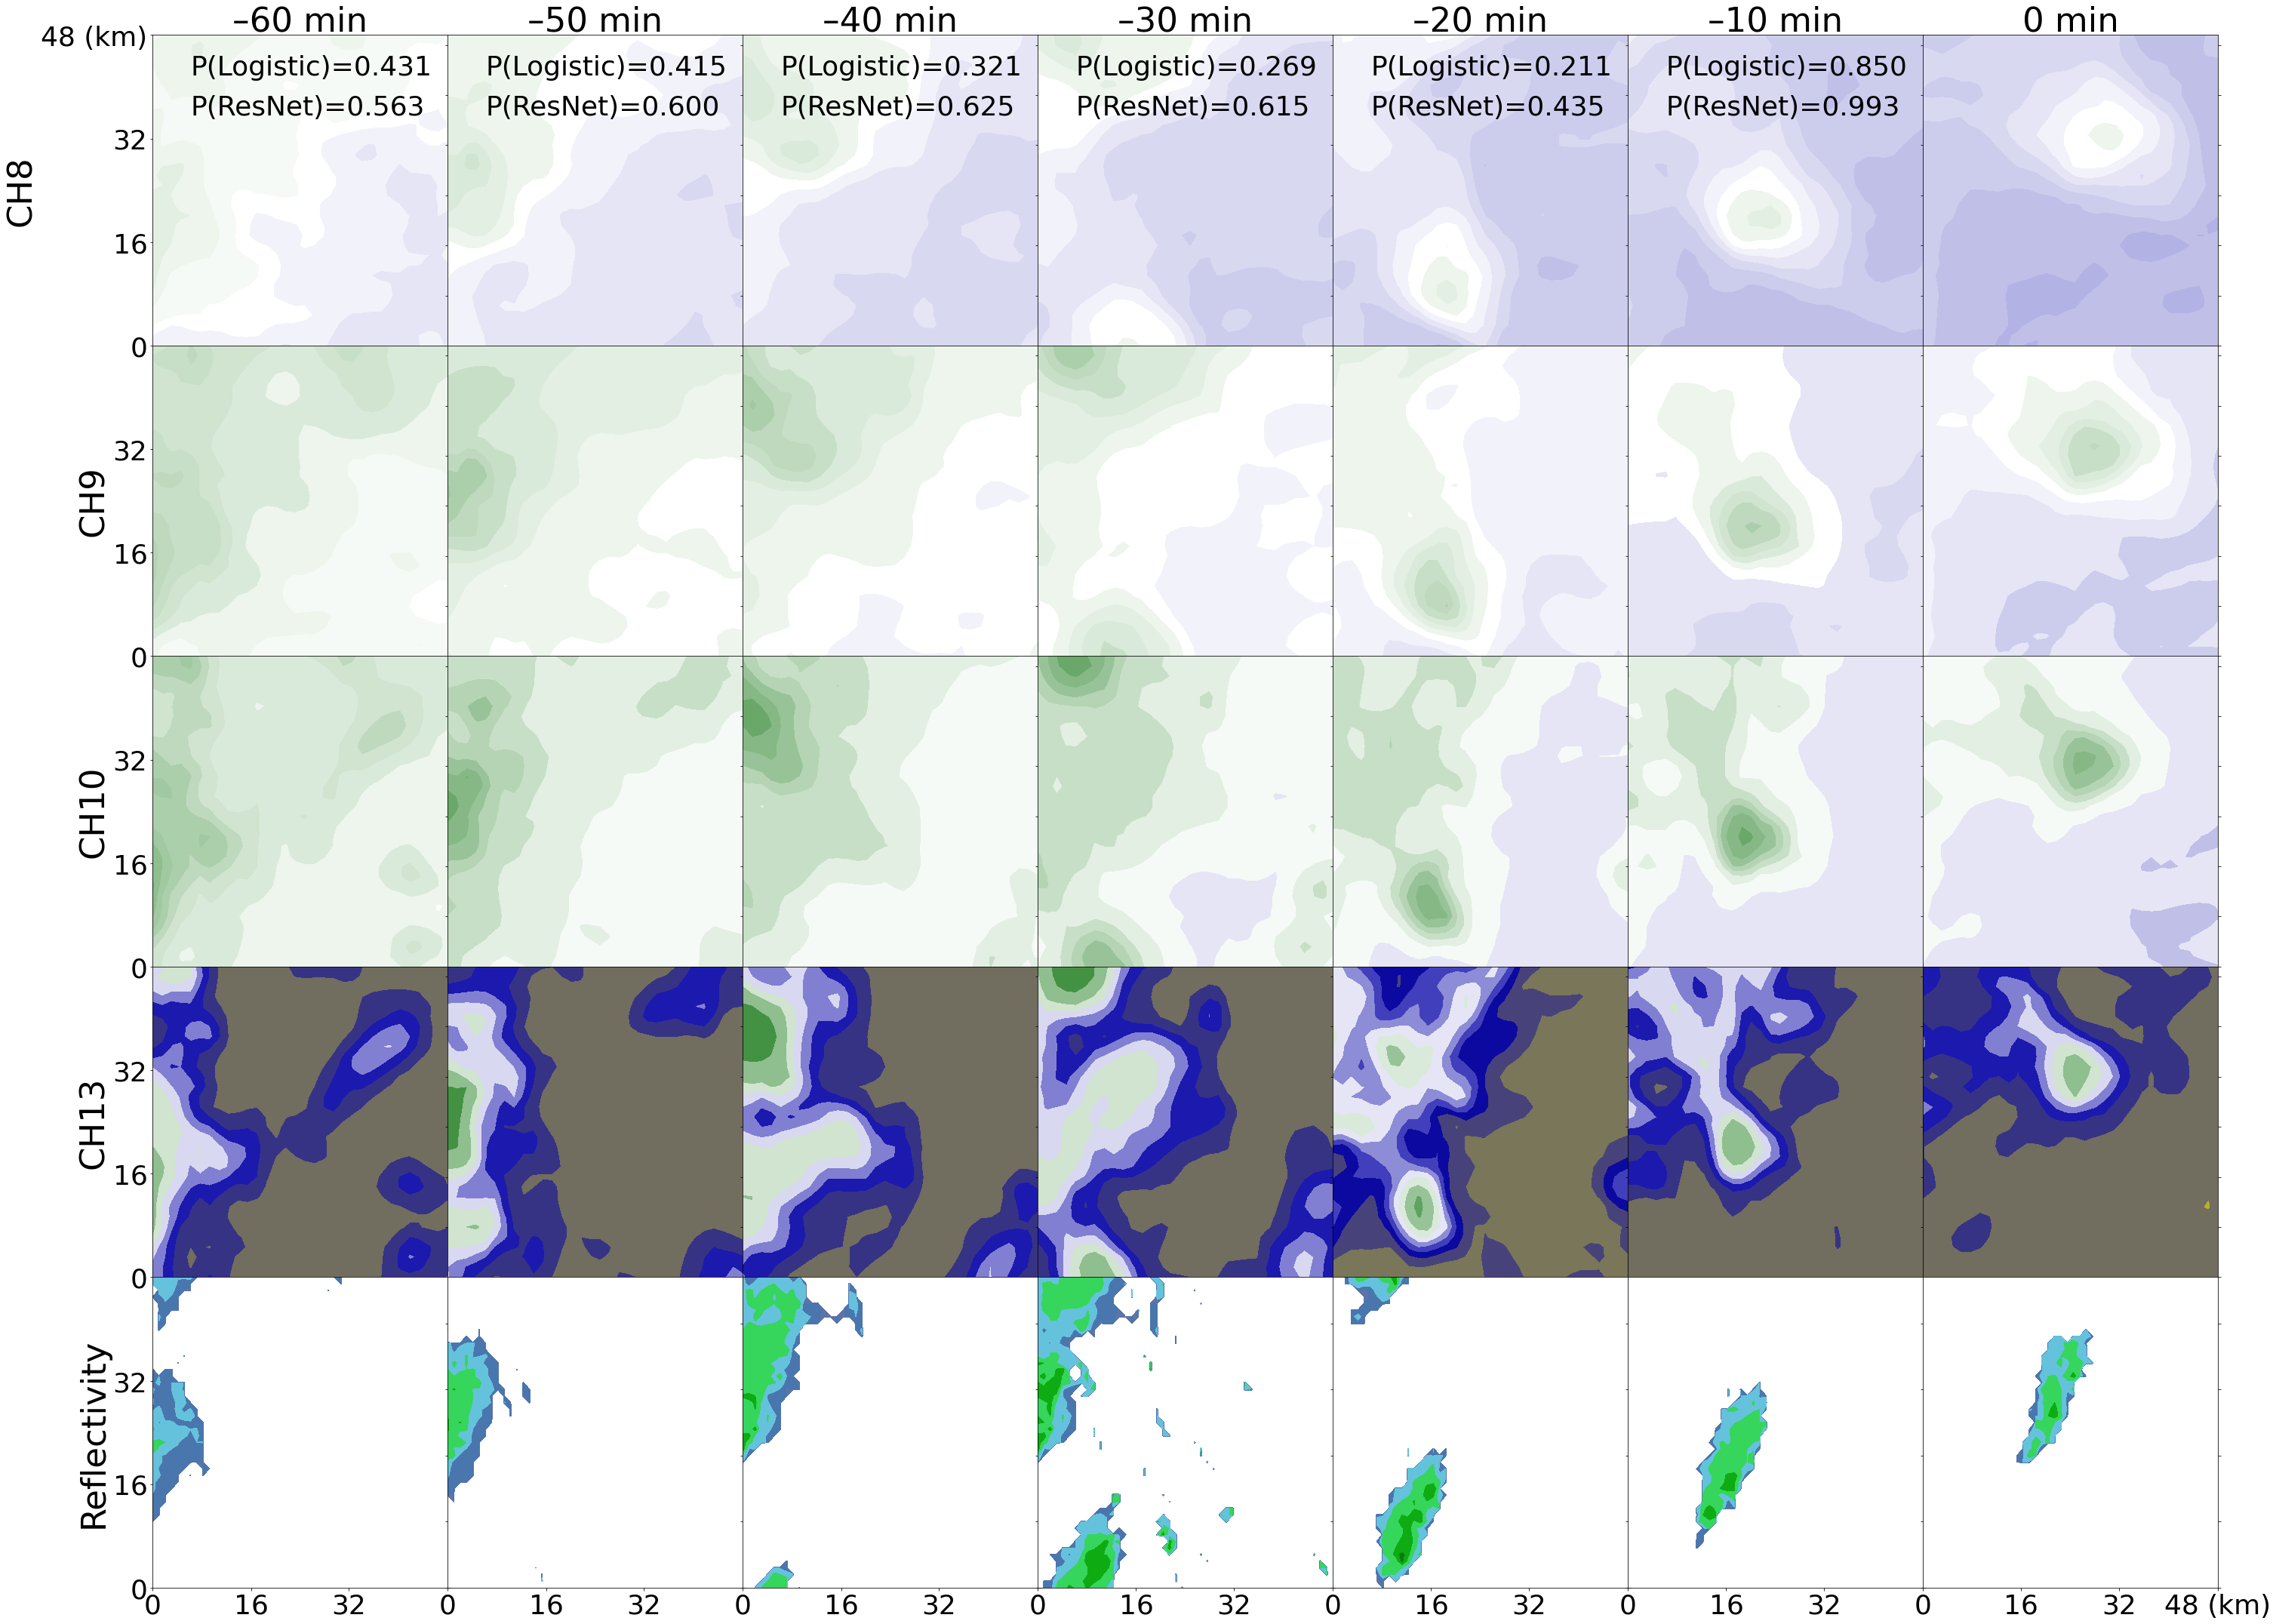

In [116]:
%matplotlib inline
from metpy.plots import colortables
#from metpy.plots import add_timestamp

from metpy.plots import colortables
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["worst_false_alarm_indices"][0]
vmin = [205,210,220,195,201,190,190]
vmax = [300,315,315,365,315,385,385] 
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
log_pred = [0.431, 0.415, 0.321, 0.269, 0.211, '0.850']
res_pred = [0.563, '0.600', 0.625, 0.615, 0.435, 0.993]
ch = [8, 9, 10, 13]
row = 5#0
column = 7
# Use a colortable/colormap available from MetPy
ctable = ('NWSStormClearReflectivity',-20,0.45)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)     

x_index = np.ones(28)*10
y_index = np.ones(28)*38
x_array = np.arange(10,38,1)
y_array = np.arange(10,38,1)

vmin_all = 160
vmax_all = 410
WV_min = [210, 215, 220, 220]
WV_max = [290, 300, 305, 335]
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        if i < 4:
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[73],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all, \
                                      cmap=wv_cmap, norm=wv_norm, N=500)
            if j == 0:
                ax[i][j].set_ylabel('CH'+str(ch[i]),fontsize=45)
            if i == 0:
                if j != 6:
                    ax[i][j].text(4, 27, 'P(Logistic)='+str(log_pred[j])+'', fontsize=36)
                    ax[i][j].text(4, 23, 'P(ResNet)='+str(res_pred[j])+'', fontsize=36)
                if j==6:
                    ax[i][j].set_title('0 min',fontsize=45)
                else:
                    ax[i][j].set_title('–'+str((6-j)*10)+' min',fontsize=45)
        else:
            processed_file = nc.Dataset(os.path.join(My_dir,files[j*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            figure = ax[i][j].contourf( 
                                        np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),
                                        norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            if j == 0:
                ax[i][j].set_ylabel('Reflectivity',fontsize=45)

        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        if j == 0:
            if i==4:
                ax[i][j].set_yticks((0, 15.66, 31.23))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].set_xticks((0, 15.66, 31.23))
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
            elif i == 0:
                ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
            else:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
            if i==4:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = True, bottom = True)
            else:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
        else:
            if i==4:
                if j == 6:
                    ax[i][j].set_xticks((0, 15.66, 31.23, 47))
                    ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_xticks((0, 15.66, 31.23))
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
            else: 
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = False, bottom = False)     
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

#plt.savefig('plots/false_alarms_case1_all.png')

### (optional) make animation for better illustration

In [120]:
# plot gif
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
row = 1
column = 5
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

def animate(k):
    plt.gca().clear()
    for i in range(column):
        if i < 4:
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i].contourf(np.squeeze(test_images_shuffled[index[73],:,:,ch[i]-8+(6-k)*7]), vmin=vmin_all, vmax=vmax_all, \
                                      cmap=wv_cmap, norm=wv_norm, N=500)
            ax[i].set_title('CH'+str(ch[i]),fontsize=36)
        else:
            processed_file = nc.Dataset(os.path.join(My_dir,files[k*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            a = ax[i].contourf( np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),\
                                norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            ax[i].set_title('Reflectivity',fontsize=36)
        if i==4:
            ax[i].set_xticks((0, 15.66, 31.23, 47))
            ax[i].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_yticks((0, 15.66, 31.23, 47))
            ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=24)
        elif i == 0:
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            ax[i].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
        else:
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
            ax[i].set_yticks((0, 10.33, 20.66, 31))
        if i==0:
            ax[i].tick_params(left = True, right = False , labelleft = True,
            labelbottom = True, bottom = True)
        else:
            ax[i].tick_params(left = True, right = False , labelleft = False,
            labelbottom = True, bottom = True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=-0.5)
    if k < 6:
        fig.suptitle("t = "+str((k-6)*10)+"min [P(ResNet)="+str(res_pred[k])+"]",fontsize=40,y=0.95)
    else:
        fig.suptitle("t = "+str((k-6)*10)+"min ",fontsize=40,y=0.95)


ani = FuncAnimation(fig, animate, frames=range(7),
                    interval=2000, repeat=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
ani.save("plots/Worst_FA_animation_BN_test123.gif", writer='imagemagick', dpi = 300)

<IPython.core.display.Javascript object>

# Plot hit case

### Load radar reflectivity 

In [6]:
# For hit case:
index=test_lead10_all_indices["best_hit_indices"][0]
import datetime
def time_plus_2h(initial_date):
    return str(datetime.datetime.strptime(initial_date,'%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=2))
i=63#82
lon_center = lon_0[index[i]]
lat_center = lat_0[index[i]]
print(time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[i]]))))
print(lon_0[index[i]])
print(lat_0[index[i]])
My_dir = '/glade/scratch/fanda/files/MergedReflectivityQCComposite/06/MergedReflectivityQCComposite/00.50'
testfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
#testfiles.sort
files = []
for i in testfiles:
    if i[9:15]>'065500' and i[9:15]<'075700':
        files.append(i)
files=sorted(files)
print(len(files))
processed_file=nc.Dataset(os.path.join(My_dir,files[0]))
dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
interval = processed_file.LatGridSpacing
lon_grid, lat_grid = np.meshgrid(np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval),
                                 np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[0],-interval))
lat_target_0 = lat_center-0.24#42.75-0.1#34.93#39#34.93 43.23 -98.14 42.75 -97.66
lat_target_1 = lat_center+0.24 #43.23+0.1#35.41#42#35.41+0.01
lon_target_0 = lon_center-0.24#-98.14-0.1#-98.79#-99#-98.79
lon_target_1 = lon_center+0.24#-97.66+0.1#-98.31#-96#-98.31-0.01
lon_1d = np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval)
lat_1d = np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[1],-interval)
lat_index_0 = np.where(np.abs(lat_1d-lat_target_0)<0.001)
lat_index_1 = np.where(np.abs(lat_1d-lat_target_1)<0.001)
lon_index_0 = np.where(np.abs(lon_1d-lon_target_0)<0.001)
lon_index_1 = np.where(np.abs(lon_1d-lon_target_1)<0.001)

2021-06-06 07:56:48
-101.48
35.3
31


### Load satellite observation and make the plot

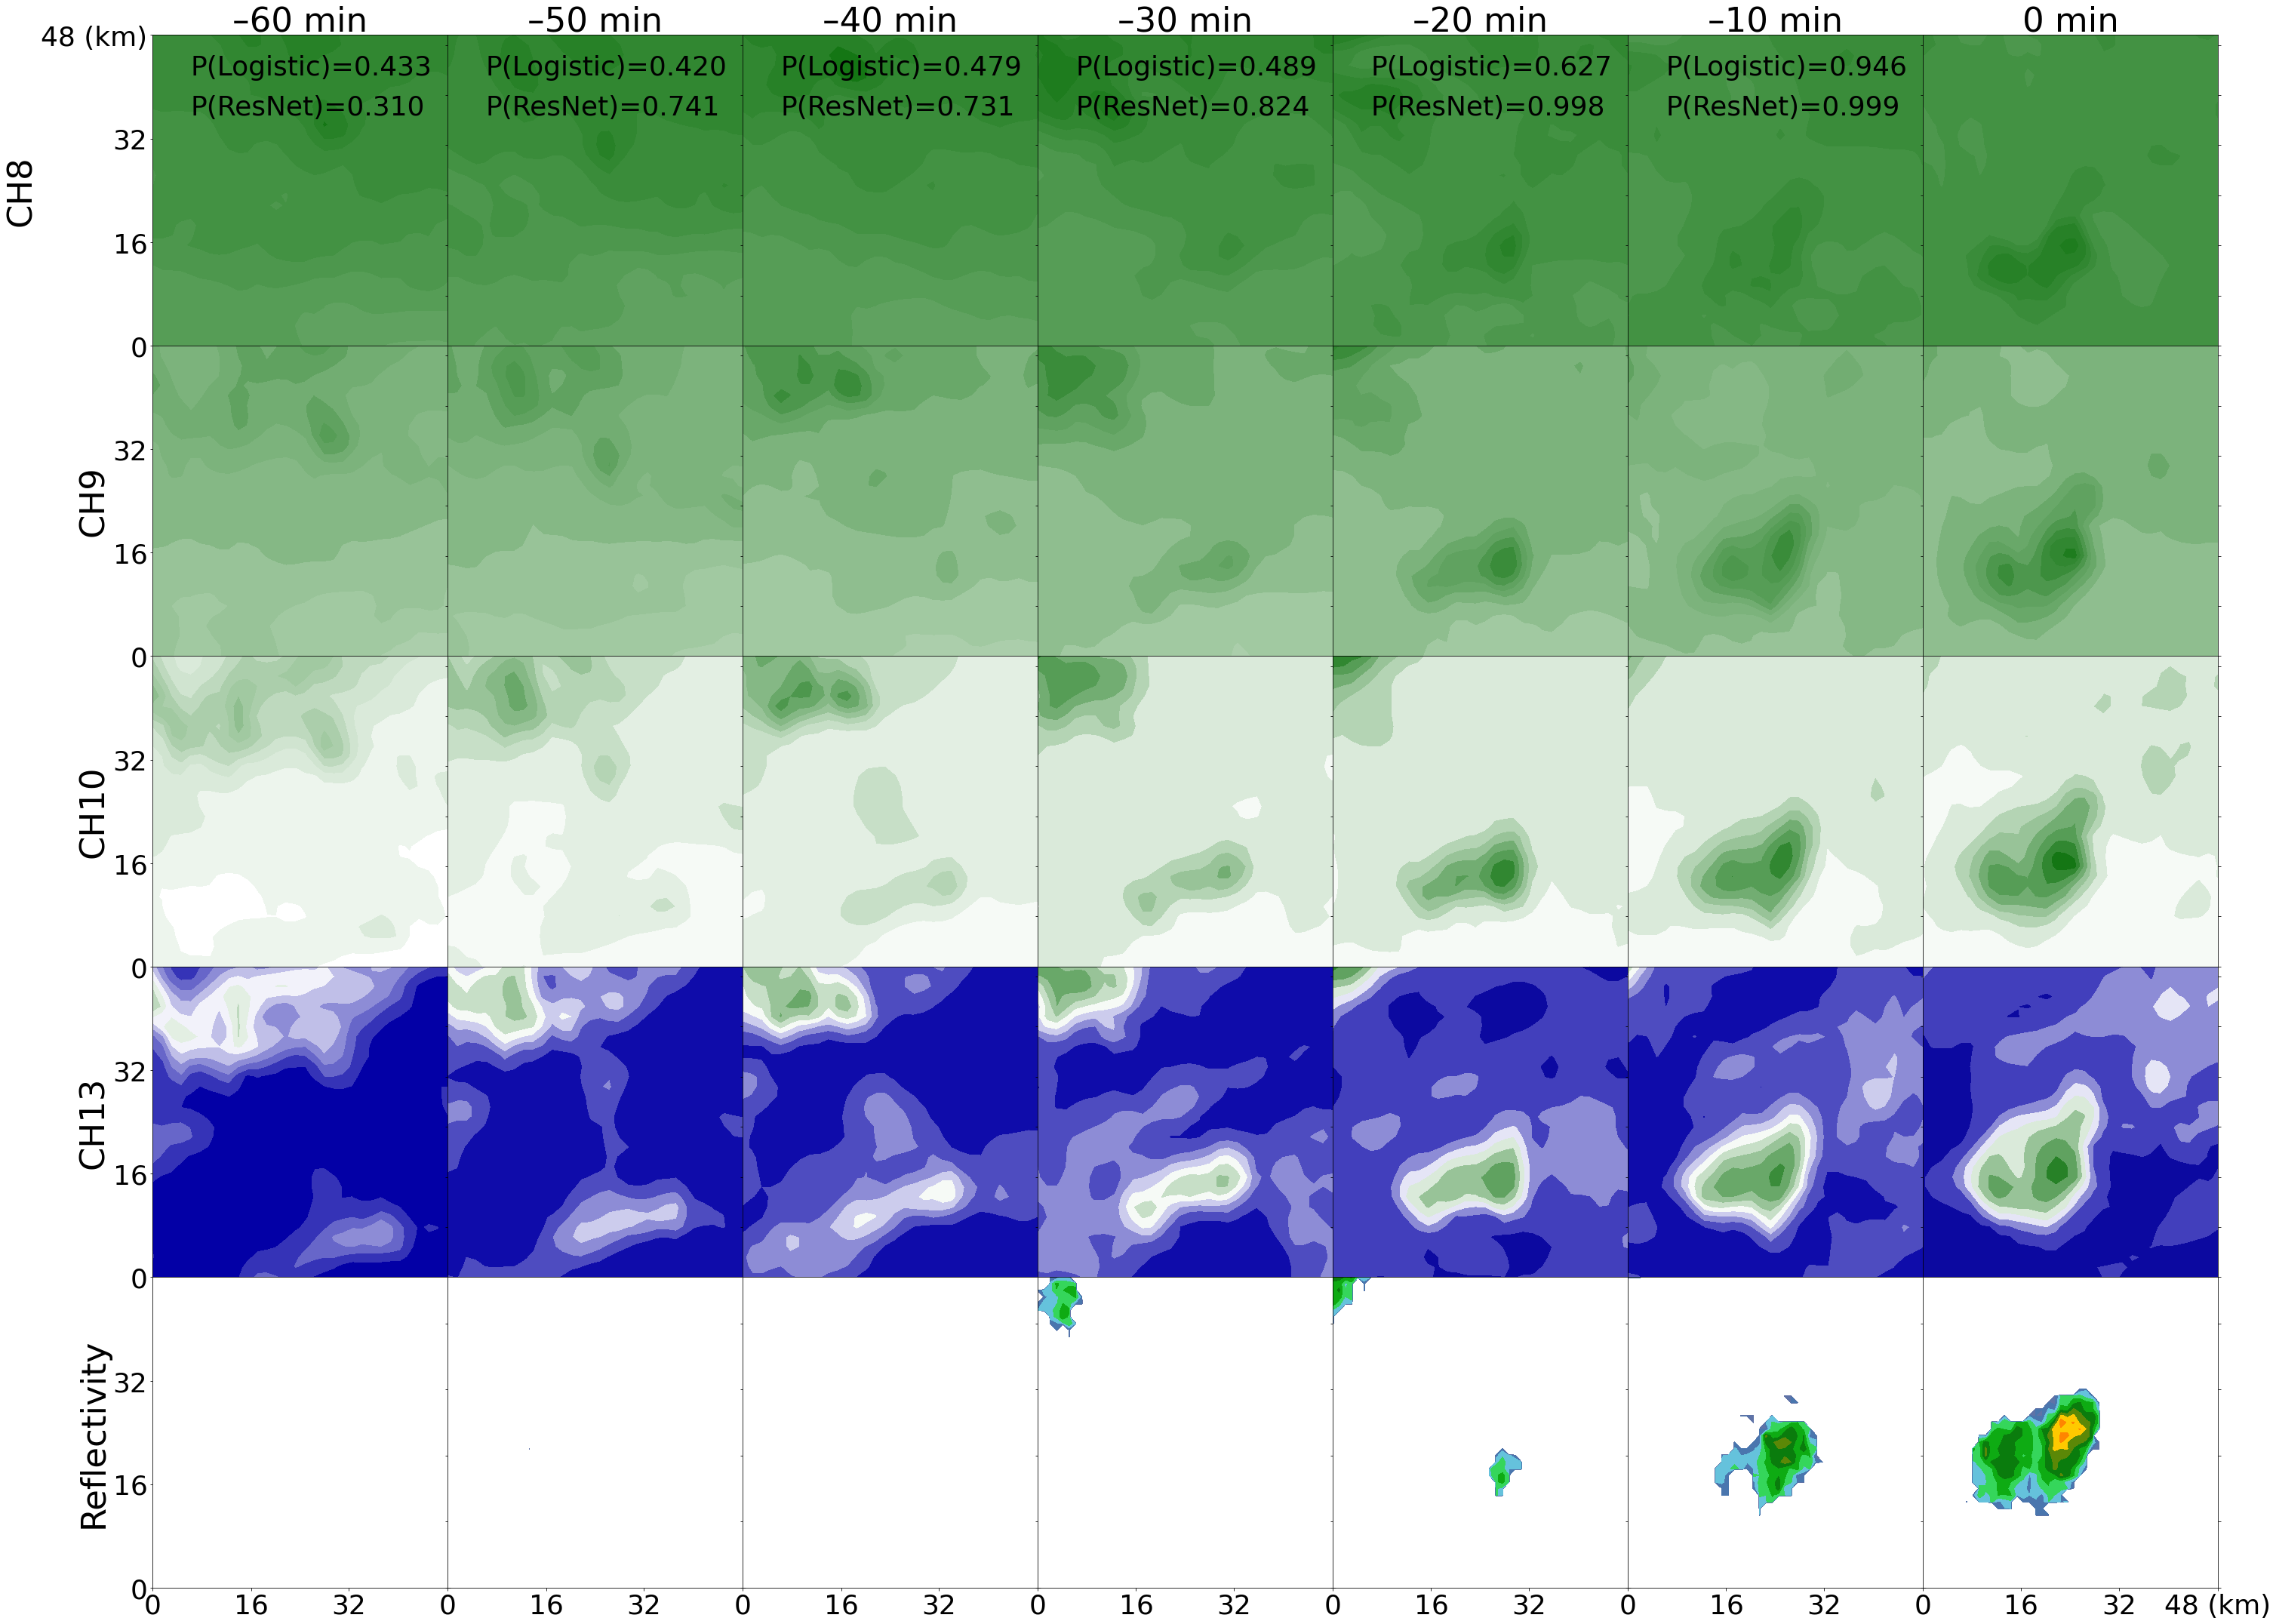

In [8]:
from metpy.plots import colortables
#from metpy.plots import add_timestamp

from metpy.plots import colortables
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
vmax = [300,315,315,365,315,385,385] 
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
log_pred = [0.433, '0.420', 0.479, 0.489, 0.627, 0.946]
res_pred = ['0.310' , 0.741, 0.731, 0.824, 0.998, 0.999]
ch = [8, 9, 10, 13]
row = 5#0
column = 7
# Use a colortable/colormap available from MetPy
ctable = ('NWSStormClearReflectivity',-20,0.45)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)     
x_index = np.ones(28)*10
y_index = np.ones(28)*38
x_array = np.arange(10,38,1)
y_array = np.arange(10,38,1)
vmin_all = 160
vmax_all = 410
WV_min = [210, 215, 220, 220]
WV_max = [290, 300, 305, 335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        if i < 4:
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[63],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
                                      cmap=wv_cmap, norm=wv_norm, N=500)
            if j == 0:
                ax[i][j].set_ylabel('CH'+str(ch[i]),fontsize=45)
            if i == 0:
                if j != 6:
                    ax[i][j].text(4, 27, 'P(Logistic)='+str(log_pred[j])+'', fontsize=36)
                    ax[i][j].text(4, 23, 'P(ResNet)='+str(res_pred[j])+'', fontsize=36)
                if j==6:
                    ax[i][j].set_title('0 min',fontsize=45)
                else:
                    ax[i][j].set_title('–'+str((6-j)*10)+' min',fontsize=45)
        else:
            processed_file = nc.Dataset(os.path.join(My_dir,files[j*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            figure = ax[i][j].contourf( 
                                        np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),
                                        norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            if j == 0:
                ax[i][j].set_ylabel('Reflectivity',fontsize=45)

        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        
        if j == 0:
            if i==4:
                ax[i][j].set_yticks((0, 15.66, 31.23))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].set_xticks((0, 15.66, 31.23))
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
            elif i == 0:
                ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
            else:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
            if i==4:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = True, bottom = True)
            else:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
        else:
            if i==4:
                if j == 6:
                    ax[i][j].set_xticks((0, 15.66, 31.23, 47))
                    ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_xticks((0, 15.66, 31.23))
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
            else: 
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = False, bottom = False) 
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/hits_case3_new_all.png')

### (optional) make animation for better illustration

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
row = 1
column = 5
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

def animate(k):
    plt.gca().clear()
    for i in range(column):
        if i < 4:
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i].contourf(np.squeeze(test_images_shuffled[index[63],:,:,ch[i]-8+(6-k)*7]), vmin=vmin_all, vmax=vmax_all,\
                                          cmap=wv_cmap, norm=wv_norm, N=500)
            ax[i].set_title('CH'+str(ch[i]),fontsize=36)
        else:
            processed_file = nc.Dataset(os.path.join(My_dir,files[k*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            a = ax[i].contourf( np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),\
                                norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            ax[i].set_title('Reflectivity',fontsize=36)
        if i==4:
            ax[i].set_xticks((0, 15.66, 31.23, 47))
            ax[i].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_yticks((0, 15.66, 31.23, 47))
            ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=24)
        elif i == 0:
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            ax[i].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
        else:
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            #ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=30)
            #ax[i].set_yticklabels(('0', '16', '32'), fontsize=36)
        if i==0:
            ax[i].tick_params(left = True, right = False , labelleft = True,
            labelbottom = True, bottom = True)
        else:
            ax[i].tick_params(left = True, right = False , labelleft = False,
            labelbottom = True, bottom = True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=-0.5)
    if k < 6:
        fig.suptitle("t = "+str((k-6)*10)+"min [P(ResNet)="+str(res_pred[k])+"]",fontsize=40,y=0.95)
    else:
        fig.suptitle("t = "+str((k-6)*10)+"min ",fontsize=40,y=0.95)
ani = FuncAnimation(fig, animate, frames=range(7),
                    interval=2000, repeat=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
ani.save("plots/Best_Hits_animation_BN_test123.gif", writer='imagemagick', dpi = 300)